# Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

# preparing dataset

In [3]:
file_path = '/content/drive/MyDrive/action_recognition/dataset20.csv'
dataset = pd.read_csv(file_path) #reading the dataset

In [4]:
print(dataset.shape) #checking its shape

(321428, 21)


In [5]:
dataset.head() #taking a look at the dataset

,lastSensorEventHours,lastSensorEventSeconds,windowDuration,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-OutsideDoor,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-DiningRoom,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-OutsideDoor,label
0,-0.439845,-0.407339,-0.283800,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.433035,-0.500411,-0.806492,4.371657,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706324,26
1,-0.439845,-0.407291,-0.282950,-1.545536,-1.545432,1.731450,1.731450,1.465175,-0.455621,-0.510093,1.457228,-0.500411,-0.806492,4.301066,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706652,26
2,-0.439845,-0.401850,-0.189541,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.443221,-0.500411,-0.806492,4.341935,13.780628,15.748974,10.111505,12.958303,18.366668,-0.686144,26
3,-0.439845,-0.401658,-0.186993,-1.545536,-1.545432,0.180151,0.180151,1.465175,-0.455621,-0.510093,1.429215,-0.500411,-0.806492,4.382803,13.780628,15.748974,10.111505,12.958303,18.366668,-0.685372,26
4,-0.439845,-0.401658,-0.187842,-1.545536,-1.545432,1.731450,1.731450,1.465175,-0.455621,-0.510093,1.287872,-0.500411,-0.806492,4.795202,13.780628,15.748974,10.111505,12.958303,18.366668,-0.706652,26


In [6]:
def generate_seqences(dataset): #this function returns our sequences and their labels
  sequences = [] #sequences will be stored in this list
  labels = [] #labels of seaquences will be stored in this list
  time_step = 16 #each seq will include 16 rows of our table
  stride = 1  #number of rows we slide at each iteration
  num_sequences = len(dataset) - time_step + stride #number of sequences
  for i in range(num_sequences):
    start = i #fist index of sequence number i
    end = i + time_step - stride #last index of sequence number i
    sequences.append(dataset.iloc[start:end+1,:-1]) #fetching rows of features
    labels.append(dataset.iloc[end,-1]) #fetching the label of last row in a sequence
  return sequences,labels

In [7]:
sequences,labels = generate_seqences(dataset) #generates a lit of sequences 
sequences= np.stack(sequences) #numpy array of shape (num_sequences,16,21)
labels = np.stack(labels) #numpy array of shape (num_sequences,)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2) #spliting sequences into train and test sets
y_train = to_categorical(y_train) #onehot encoding
y_test = to_categorical(y_test) #onehot encoding

In [9]:
print(f"length of X_train: {X_train.shape}")
print(f"length of y_train: {y_train.shape}")
print(f"length of X_test: {X_test.shape}")
print(f"length of y_test: {y_test.shape}")

length of X_train: (257130, 16, 20)
length of y_train: (257130, 35)
length of X_test: (64283, 16, 20)
length of y_test: (64283, 35)


# defining and training an LSTM model

In [ ]:
num_epochs = 10
num_timesteps, num_features, num_classes =   X_train.shape[1], X_train.shape[2], y_train.shape[1]


model = Sequential()
model.add(LSTM(200, input_shape=(num_timesteps,num_features), return_sequences=True))
#adding and LSTM layer with 200 neurons .  this layer returs sequences because our next layer is also LSTM
model.add(LSTM(200))
#adding and LSTM layer with 200 neurons

model.add(Dense(100, activation='relu'))
#adding a dense layer with 100 neurons and relu activation
model.add(Dense(num_classes, activation='softmax'))
#adding a dense layer with 35 neurons and softmax activaion

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#compling the model with categorical cross entropy loss function and adam optimizer

start_time = time.time() #start time of training
history = model.fit(X_train, y_train, validation_split=0.1, epochs=num_epochs, batch_size=64) #training the model
print(f'elapsed time: {time.time() - start_time}') #print the time duration of training

Epoch 1/10
3616/3616 [==============================] - 34s 8ms/step - loss: 0.7798 - accuracy: 0.7288 - val_loss: 0.5985 - val_accuracy: 0.7801
Epoch 2/10
3616/3616 [==============================] - 27s 7ms/step - loss: 0.4921 - accuracy: 0.8190 - val_loss: 0.4275 - val_accuracy: 0.8419
Epoch 3/10
3616/3616 [==============================] - 25s 7ms/step - loss: 0.3675 - accuracy: 0.8647 - val_loss: 0.3406 - val_accuracy: 0.8755
Epoch 4/10
3616/3616 [==============================] - 27s 7ms/step - loss: 0.2932 - accuracy: 0.8918 - val_loss: 0.2856 - val_accuracy: 0.8939
Epoch 5/10
3616/3616 [==============================] - 26s 7ms/step - loss: 0.2431 - accuracy: 0.9104 - val_loss: 0.2509 - val_accuracy: 0.9097
Epoch 6/10
3616/3616 [==============================] - 25s 7ms/step - loss: 0.2119 - accuracy: 0.9216 - val_loss: 0.2270 - val_accuracy: 0.9163
Epoch 7/10
3616/3616 [==============================] - 25s 7ms/step - loss: 0.1864 - accuracy: 0.9311 - val_loss: 0.2170 - val_ac

# Evaluating

In [ ]:
_ ,accuracy = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
print(accuracy)

0.9414153099060059


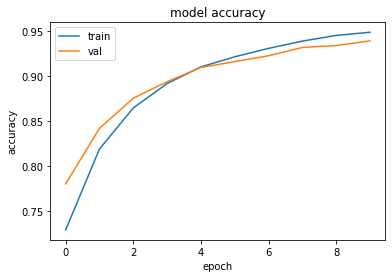

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

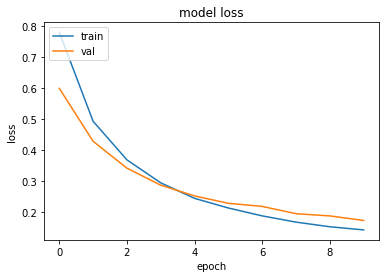

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Dynamic hyperparameter tuning

In [10]:
!pip install keras-tuner==1.0.0

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 462 kB 11.1 MB/s 


In [11]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [22]:
def build_model(hp):
  num_timesteps, num_features, num_classes =   X_train.shape[1], X_train.shape[2], y_train.shape[1]
  model = Sequential()
  model.add(LSTM(hp.Int("input_units", min_value=50, max_value=200, step=50), input_shape=(num_timesteps,num_features), return_sequences=True))

  for i in range (hp.Int("n_layers",1,5)):
    model.add(LSTM(hp.Int(f"input_{i}_units", min_value=50, max_value=200, step=50)))

  model.add(Dense(100, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 1,
    executions_per_trial = 1
)

In [24]:
tuner.search(x=X_train,
             y=y_train,
             epochs = 10,
             batch_size = 256,
             validation_data = (X_test, y_test))

Epoch 1/10
1005/1005 [==============================] - 27s 23ms/step - loss: 0.8527 - accuracy: 0.7136 - val_loss: 0.6138 - val_accuracy: 0.7791
Epoch 2/10
1005/1005 [==============================] - 23s 23ms/step - loss: 0.5248 - accuracy: 0.8107 - val_loss: 0.4667 - val_accuracy: 0.8313
Epoch 3/10
1005/1005 [==============================] - 22s 22ms/step - loss: 0.3978 - accuracy: 0.8547 - val_loss: 0.3538 - val_accuracy: 0.8704
Epoch 4/10
1005/1005 [==============================] - 23s 23ms/step - loss: 0.3150 - accuracy: 0.8858 - val_loss: 0.3119 - val_accuracy: 0.8861
Epoch 5/10
1005/1005 [==============================] - 22s 22ms/step - loss: 0.2602 - accuracy: 0.9048 - val_loss: 0.2541 - val_accuracy: 0.9077
Epoch 6/10
1005/1005 [==============================] - 23s 23ms/step - loss: 0.2223 - accuracy: 0.9191 - val_loss: 0.2264 - val_accuracy: 0.9183
Epoch 7/10
1005/1005 [==============================] - 22s 22ms/step - loss: 0.1928 - accuracy: 0.9304 - val_loss: 0.2208 -

INFO:tensorflow:Oracle triggered exit
